In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, BatchNormalization
from tensorflow.keras import backend as k
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from six.moves import xrange
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GRU, Lambda, TimeDistributed
from tensorflow.keras.optimizers.legacy import RMSprop, Adam
from tensorflow.keras.callbacks import History, TerminateOnNaN

np.random.seed(2)
pd.set_option("display.max_rows", 1000)

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from wtte import weibull as weibull
from wtte import wtte as wtte
from wtte import pipelines as pipelines
from wtte.wtte import WeightWatcher

In [4]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols

In [5]:
np.set_printoptions(suppress=True, threshold=10000)
path = "/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/wtte_keras/"
train_orig = pd.read_csv(path+'train.csv', header=None, names=column_names)
test_x_orig = pd.read_csv(path+'test_x.csv', header=None, names=column_names)
test_y_orig = pd.read_csv(path+'test_y.csv', header=None, names=['T'])

In [6]:
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1           0.0023        0.0003         100.0   
            2          -0.0027       -0.0003         100.0   
            3           0.0003        0.0001         100.0   
            4           0.0042        0.0000         100.0   
            5           0.0014        0.0000         100.0   
...                        ...           ...           ...   
100         194         0.0049        0.0000         100.0   
            195        -0.0011       -0.0001         100.0   
            196        -0.0006       -0.0003         100.0   
            197        -0.0038        0.0001         100.0   
            198         0.0013        0.0003         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                643.02   
            2                   518.67                641.71   
            3                   518.67                642.46   
            4                   518.67                642.44   
            5                   518.67                642.51   
...                                ...                   ...   
100         194                 518.67                643.24   
            195                 518.67                643.22   
            196                 518.67                643.44   
            197                 518.67                643.26   
            198                 518.67                642.95   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1585.29               1398.21   
            2                  1588.45               1395.42   
            3                  1586.94               1401.34   
            4                  1584.12               1406.42   
            5                  1587.19               1401.92   
...                                ...                   ...   
100         194                1599.45               1415.79   
            195                1595.69               1422.05   
            196                1593.15               1406.82   
            197                1594.99               1419.36   
            198                1601.62               1424.99   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   
...                                ...                   ...   
100         194                  14.62                 21.61   
            195                  14.62                 21.61   
            196                  14.62                 21.61   
            197                  14.62                 21.61   
            198                  14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                   553.90  ...                 521.72   
            2                   554.85  ...                 522.16   
            3                   554.11  ...                 521.97   
            4                   554.07  ...                 521.38   
            5                   554.16  ...                 522.15   
...                                ...  ...                    ...   
100         194                 553.41  ...                 520.69   
            195                 553.22  ...                 521.05   
            

In [7]:
train_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1          -0.0007       -0.0004         100.0   
            2           0.0019       -0.0003         100.0   
            3          -0.0043        0.0003         100.0   
            4           0.0007        0.0000         100.0   
            5          -0.0019       -0.0002         100.0   
...                        ...           ...           ...   
100         196        -0.0004       -0.0003         100.0   
            197        -0.0016       -0.0005         100.0   
            198         0.0004        0.0000         100.0   
            199        -0.0011        0.0003         100.0   
            200        -0.0032       -0.0005         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                641.82   
            2                   518.67                642.15   
            3                   518.67                642.35   
            4                   518.67                642.35   
            5                   518.67                642.37   
...                                ...                   ...   
100         196                 518.67                643.49   
            197                 518.67                643.54   
            198                 518.67                643.42   
            199                 518.67                643.23   
            200                 518.67                643.85   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1589.70               1400.60   
            2                  1591.82               1403.14   
            3                  1587.99               1404.20   
            4                  1582.79               1401.87   
            5                  1582.85               1406.22   
...                                ...                   ...   
100         196                1597.98               1428.63   
            197                1604.50               1433.58   
            198                1602.46               1428.18   
            199                1605.26               1426.53   
            200                1600.38               1432.14   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   
...                                ...                   ...   
100         196                  14.62                 21.61   
            197                  14.62                 21.61   
            198                  14.62                 21.61   
            199                  14.62                 21.61   
            200                  14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                   554.36  ...                 521.66   
            2                   553.75  ...                 522.28   
            3                   554.26  ...                 522.42   
            4                   554.45  ...                 522.86   
            5                   554.00  ...                 522.19   
...                                ...  ...                    ...   
100         196                 551.43  ...                 519.49   
            197                 550.86  ...                 519.68   
            

In [11]:
# Combine the X values to normalize them,
all_data_orig = pd.concat([train_orig, test_x_orig])
# all_data = all_data[feature_cols]
# all_data[feature_cols] = normalize(all_data[feature_cols].values)

scaler=pipeline.Pipeline(steps=[
#     ('z-scale', StandardScaler()),
     ('minmax', MinMaxScaler(feature_range=(-1, 1))),
     ('remove_constant', VarianceThreshold())
])

all_data = all_data_orig.copy()
all_data = np.concatenate([all_data[['unit_number', 'time']],
                          scaler.fit_transform(all_data[feature_cols])], axis=1)
print(all_data.shape)
type(all_data)

(33727, 19)


numpy.ndarray

In [12]:
# then split them back out
train = all_data[0:train_orig.shape[0], :]
test = all_data[train_orig.shape[0]:, :]
# Make engine numbers and days zero-indexed, for everybody's sanity
train[:, 0:2] -= 1
test[:, 0:2] -= 1
type(train[:, 0])

numpy.ndarray

In [10]:
# # Configurable observation look-back period for each engine/day
max_time = 100
mask_value = -99

train_x, train_y = pipelines.build_data(unit=train[:, 0], time=train[:, 1], x=train[:, 2:],
                                        look_back=max_time, is_test=False, mask_value=mask_value)
test_x, _ = pipelines.build_data(unit=test[:, 0], time=test[:, 1], x=test[:, 2:],
                                 look_back=max_time, is_test=True, mask_value=mask_value)

In [16]:
# train_orig.groupby('unit_number')['time'].describe()

In [11]:
# always observed in our case
test_y = test_y_orig.copy()
test_y['E'] = 1

In [12]:
print('train_x', train_x.shape, 'train_y', train_y.shape, 'test_x', test_x.shape, 'test_y', test_y.shape)

train_x (20631, 100, 17) train_y (20631, 2) test_x (100, 100, 17) test_y (100, 2)


In [13]:
tte_mean_train = np.nanmean(train_y[:, 0])
mean_u = np.nanmean(train_y[:, 1])
# Initialization value for alpha-bias
init_alpha = -1.0/np.log(1.0 - 1.0/(tte_mean_train + 1.0))
init_alpha = init_alpha/mean_u
print('tte_mean_train', tte_mean_train, 'init_alpha: ',
      init_alpha, 'mean uncensored train: ', mean_u)

tte_mean_train 108.80786195530997 init_alpha:  109.30709957832491 mean uncensored train:  1.0


In [14]:
k.set_epsilon(1e-10)
print('epsilon', k.epsilon())
history = History()
weightwatcher = WeightWatcher()
nanterminator = TerminateOnNaN()
# reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
#                                         factor=0.5,
#                                         patience=50,
#                                         verbose=0,
#                                         mode='auto',
#                                         epsilon=0.0001,
#                                         cooldown=0,
#                                         min_lr=1e-8)
n_features = train_x.shape[-1]
# Start building our model
model = Sequential()
# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
# model.add(BatchNormalization())
# LSTM is just a common type of RNN. You could also try anything else (e.g., GRU).
model.add(GRU(20, activation='tanh', recurrent_dropout=0.25))
# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
# model.add(TimeDistributed(Dense(2)))
model.add(Dense(2))
# Apply the custom activation function mentioned above
# model.add(Activation(activate))
model.add(Lambda(wtte.output_lambda,
                 arguments={"init_alpha": init_alpha,
                            "max_beta_value": 100.0,
                            "scalefactor": 0.5
                           },
                ))
# Use the discrete log-likelihood for Weibull survival data as our loss function
loss = wtte.loss(kind='discrete', reduce_loss=False).loss_function
model.compile(loss=loss, optimizer=Adam(learning_rate=0.01, clipvalue=0.5))
# model.compile(loss=loss, optimizer=RMSprop(lr=0.01))

epsilon 1e-10
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-20 18:46:00.483179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 18:46:00.483207: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 17)          0         
                                                                 
 gru (GRU)                   (None, 20)                2340      
                                                                 
 dense (Dense)               (None, 2)                 42        
                                                                 
 lambda (Lambda)             (None, 2)                 0         
                                                                 
Total params: 2,382
Trainable params: 2,382
Non-trainable params: 0
_________________________________________________________________


In [15]:
train_y = tf.cast(train_y, tf.float32)
test_y = tf.cast(test_y, tf.float32)

In [23]:
""" model.fit(train_x, train_y,
          epochs=1,
          batch_size=500,
          verbose=1,
          validation_data=(test_x, test_y),
          callbacks=[nanterminator, history, weightwatcher]) """

' model.fit(train_x, train_y,\n          epochs=1,\n          batch_size=500, \n          verbose=1,\n          validation_data=(test_x, test_y),\n          callbacks=[nanterminator, history, weightwatcher]) '

In [16]:
# Fit!
model.fit(train_x, train_y, epochs=10, batch_size=train_x.shape[0]//10, verbose=1,
          validation_data=(test_x, test_y), callbacks=[history, weightwatcher])

Epoch 1/10


2023-02-20 18:46:40.777801: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 18:46:41.521393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 5.2017 

2023-02-20 18:49:28.863182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 169s 15s/step - loss: 5.2017 - val_loss: 4.6706
Epoch 2/10
11/11 [==============================] - 171s 16s/step - loss: 4.9936 - val_loss: 4.5851
Epoch 3/10
11/11 [==============================] - 173s 16s/step - loss: 4.9745 - val_loss: 4.7409
Epoch 4/10
11/11 [==============================] - 177s 16s/step - loss: 4.9489 - val_loss: 4.5475
Epoch 5/10
11/11 [==============================] - 175s 16s/step - loss: 4.8941 - val_loss: 4.4187
Epoch 6/10
11/11 [==============================] - 176s 16s/step - loss: 4.8946 - val_loss: 4.4834
Epoch 7/10
11/11 [==============================] - 176s 16s/step - loss: 4.8208 - val_loss: 4.5398
Epoch 8/10
11/11 [==============================] - 428s 41s/step - loss: 4.8005 - val_loss: 4.4186
Epoch 9/10
11/11 [==============================] - 171s 16s/step - loss: 4.7508 - val_loss: 4.3789
Epoch 10/10
11/11 [==============================] - 176s 16s/step - loss: 4.7378 - val_loss: 4.3552


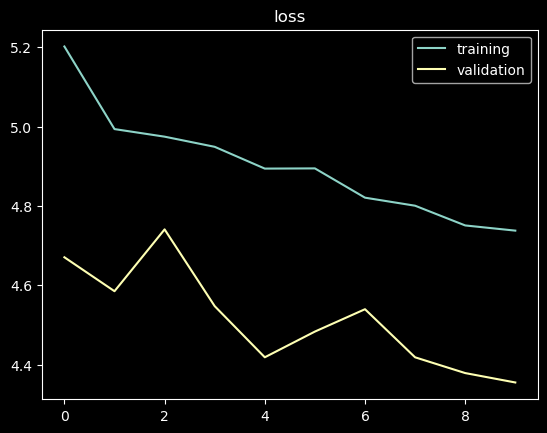

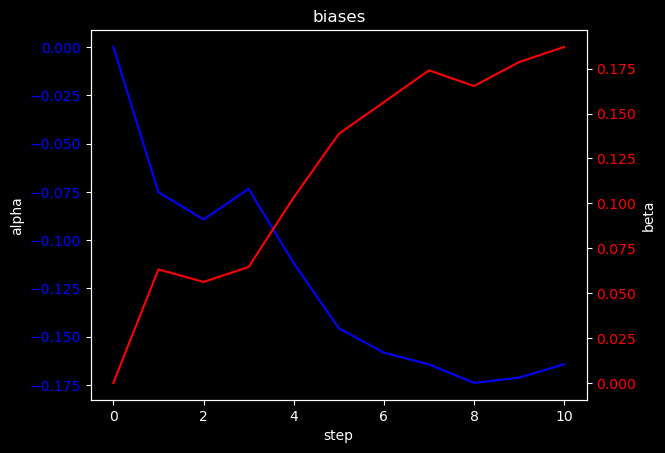

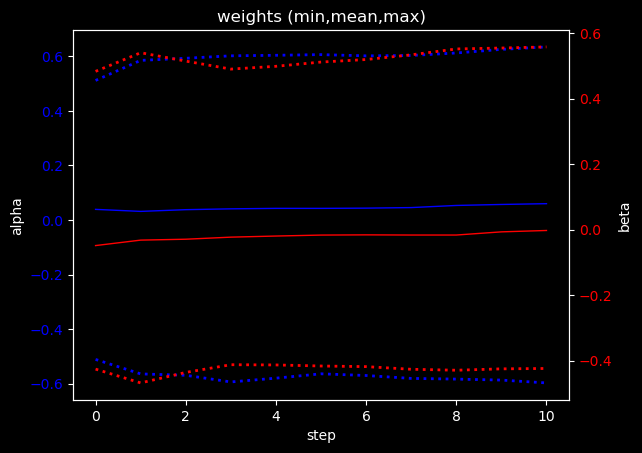

In [17]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend()
weightwatcher.plot()

In [18]:
# Make some predictions and put them alongside the real TTE and event indicator values
test_predict = model.predict(test_x)
test_predict = np.resize(test_predict, (100, 2))
test_result = np.concatenate((test_y, test_predict), axis=1)

2023-02-20 19:21:23.617597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 4s 865ms/step


In [19]:
test_results_df = pd.DataFrame(test_result, columns=['T', 'E', 'alpha', 'beta'])
test_results_df['unit_number'] = np.arange(1, test_results_df.shape[0] + 1)
# test_results_df = pd.concat([test_x_orig, test_results_df], axis=1)
# test_results_df = test_results_df.merge(test_x_orig, on=['unit_number'], how='right')

In [20]:
test_results_df

,T,E,alpha,beta,unit_number
0,112.0,1.0,219.611908,3.150178,1
1,98.0,1.0,171.893860,3.343638,2
2,69.0,1.0,84.851242,3.469380,3
3,82.0,1.0,90.833595,3.250243,4
4,91.0,1.0,115.431267,3.478629,5
5,93.0,1.0,138.262283,3.385361,6
6,91.0,1.0,108.152740,3.125772,7
7,95.0,1.0,106.378838,3.061204,8
8,111.0,1.0,173.860367,3.292632,9
9,96.0,1.0,92.498894,3.055621,10


In [21]:
test_results_df['T'].describe()

count    100.000000
mean      75.519997
std       41.764969
min        7.000000
25%       32.750000
50%       86.000000
75%      112.250000
max      145.000000
Name: T, dtype: float64

alpha 95.63837 beta 3.086827


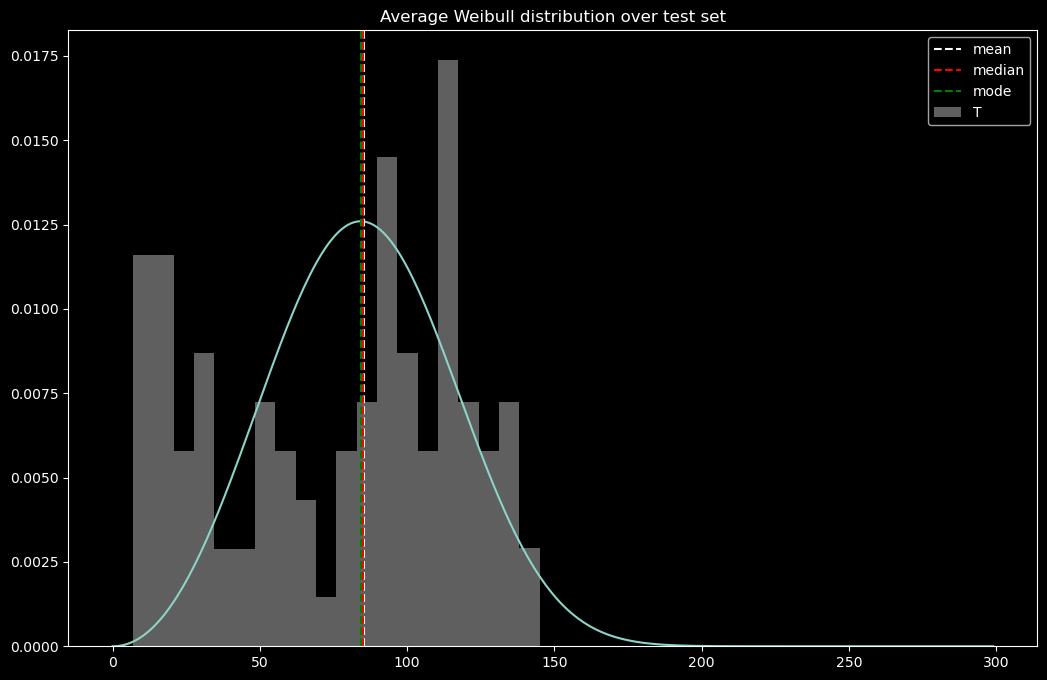

In [22]:
t=np.arange(0,300)
alpha = test_results_df['alpha'].mean()
beta = test_results_df['beta'].mean()

plt.plot(t, weibull.pdf(t, alpha, beta))
mu = weibull.mean(alpha, beta)
median =weibull.quantiles(alpha, beta, 0.5)
mode = weibull.mode(alpha, beta)
plt.axvline(mu, ls='--', label='mean')
plt.axvline(median, ls='--', color='red', label='median')
plt.axvline(mode, ls='--', color='green', label='mode')
n, bins, patches = plt.hist(test_results_df['T'], 20, density=1, facecolor='grey', alpha=0.75, label='T')
plt.legend()

plt.gcf().set_size_inches(12.5, 8)
plt.title('Average Weibull distribution over test set')
print('alpha', alpha, 'beta', beta)

In [23]:
palette=sns.color_palette("RdBu_r", 50)

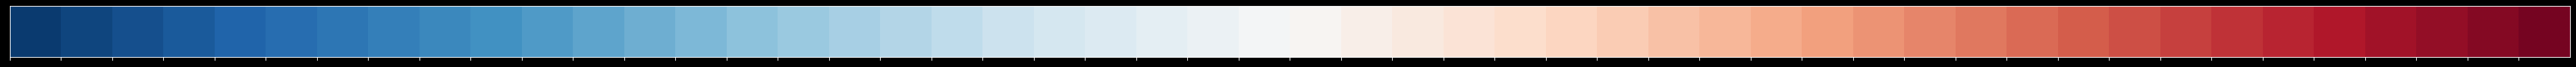

In [24]:
sns.palplot(palette)

In [25]:
train_orig.describe()

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


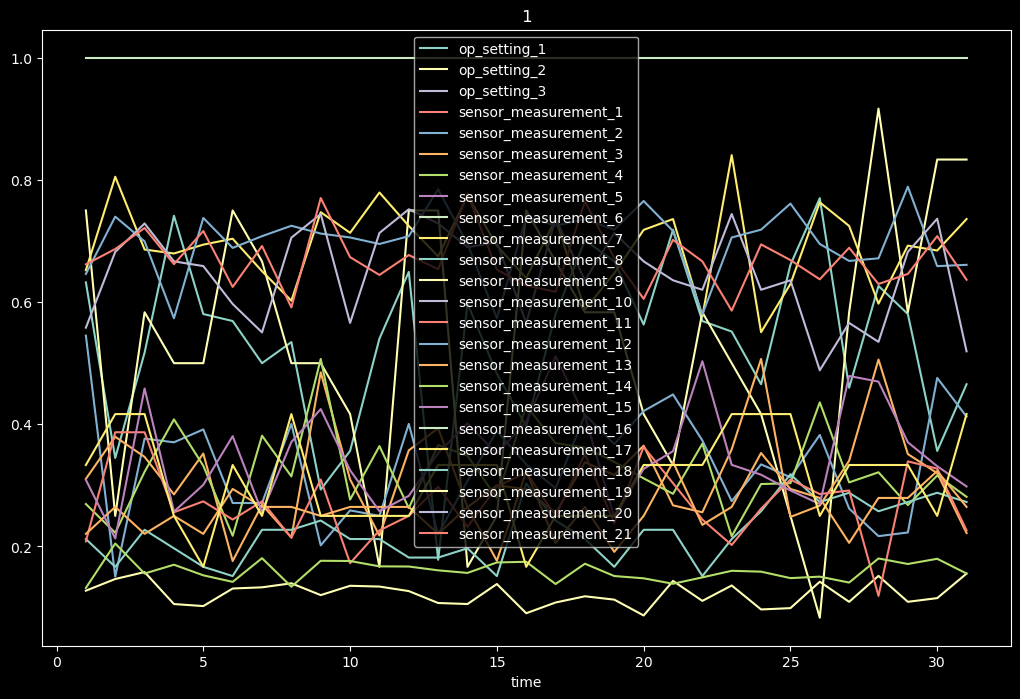

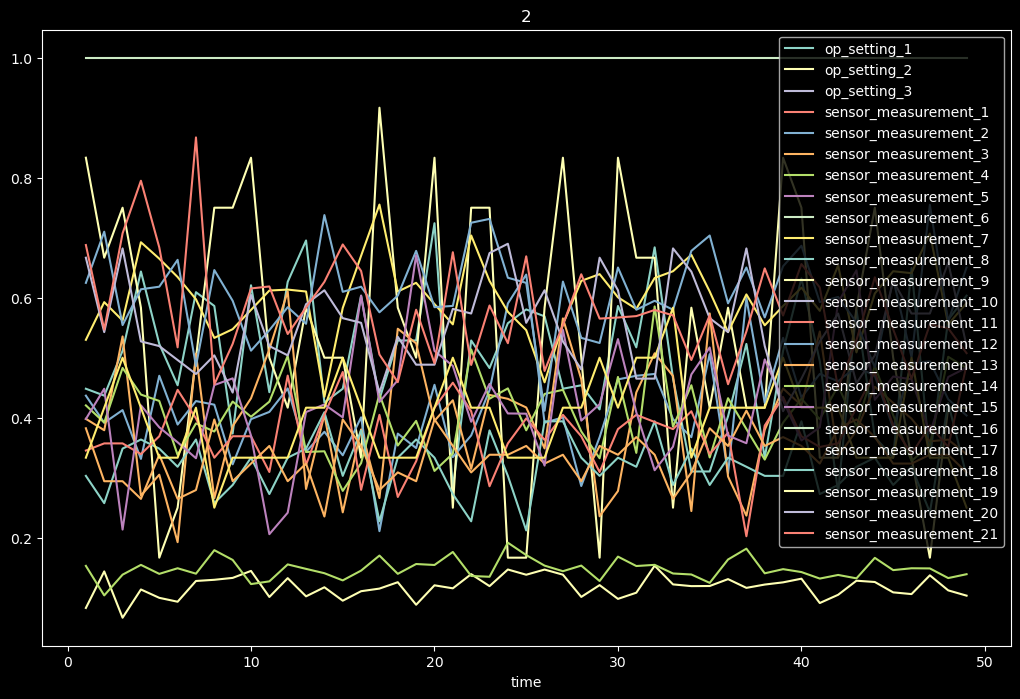

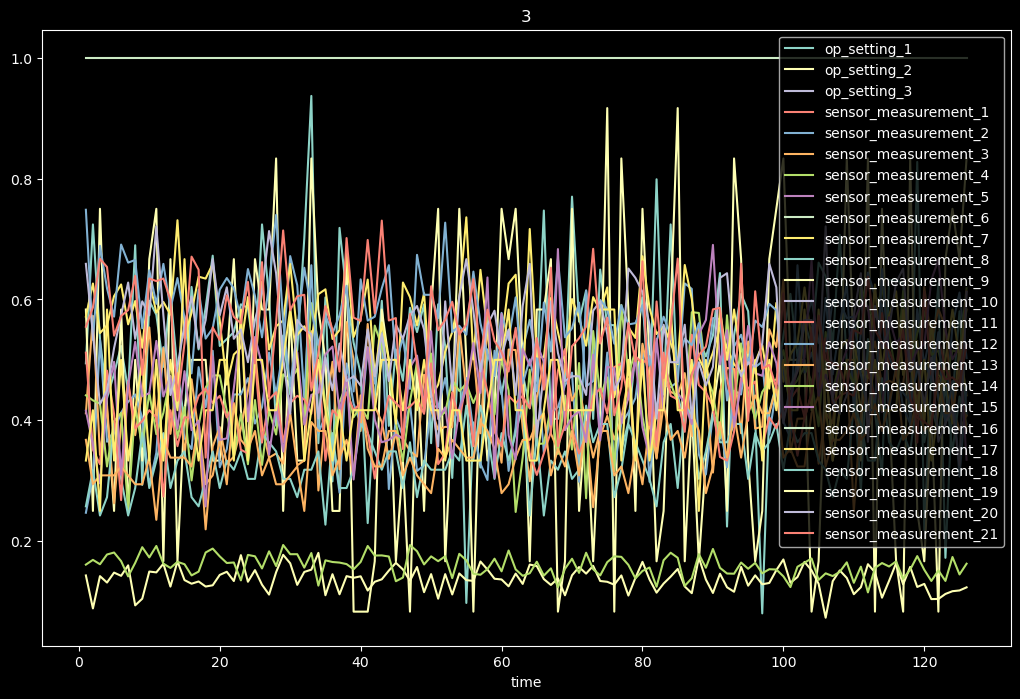

In [26]:
feature_columns = [x for x in test_x_orig.columns if x not in {'unit_number', 'time'}]
mins=train_orig[feature_columns].min()
maxs=train_orig[feature_columns].max()
for unit_no, grp in test_x_orig.groupby('unit_number'):
    if unit_no < 4:
        df=grp.set_index('time')
        df = df[feature_columns]
        df=(df - mins)/ (maxs - mins)
        df.plot(figsize=(12.5,8))
        plt.title(unit_no)
        plt.show()

In [31]:
def plot_weibull_predictions(results_df):
    fig, axarr = plt.subplots(3, figsize=(20, 30))
    t=np.arange(0, 400)
    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))
    for i, row in enumerate(results_df.iterrows()):
        alpha=row[1]['alpha']
        beta = row[1]['beta']
        T = row[1]['T']
        label = 'a={} b={}'.format(alpha, beta)
        color = color_dict[i]
        ax= axarr[0]
        mode = weibull.mode(alpha, beta)
        y_max = weibull.pdf(mode, alpha, beta)
        ax.plot(t, weibull.pdf(t, alpha, beta), color=color, label=label)
        ax.scatter(T, weibull.pdf(T, alpha, beta), color=color, s=100)
        ax.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')
        ax.set_title('Weibull distributions')
    ax=axarr[1]
    median_predictions = weibull.quantiles(results_df['alpha'], results_df['beta'], 0.5)
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull.mean(row[0], row[1]), axis=1)
    mode_predictions = weibull.mode(results_df['alpha'], results_df['beta'])
    # x = results_df['time']
    # ax.scatter(x, results_df['T'], label='survival_time', color='black')
    # ax.scatter(results_df['T'], median_predictions, label='median_prediction')
    # ax.scatter(results_df['T'], mean_predictions, label='mean_prediction')
    ax.scatter(results_df['T'], mode_predictions, label='m_prediction')
    ax.set_title('MAP prediction Vs. true')
    ax.legend()
    ax=axarr[2]
    sns.histplot(results_df['T'] - mode_predictions, ax=ax)
    ax.set_title('Error')
    # ax.plot(x, results_df['alpha'], label='alpha')
    # ax.legend()
    # ax = axarr[3]
    # ax.plot(x, results_df['beta'], label='beta')
    # ax.legend()
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # fig.suptitle(title)
    plt.show()

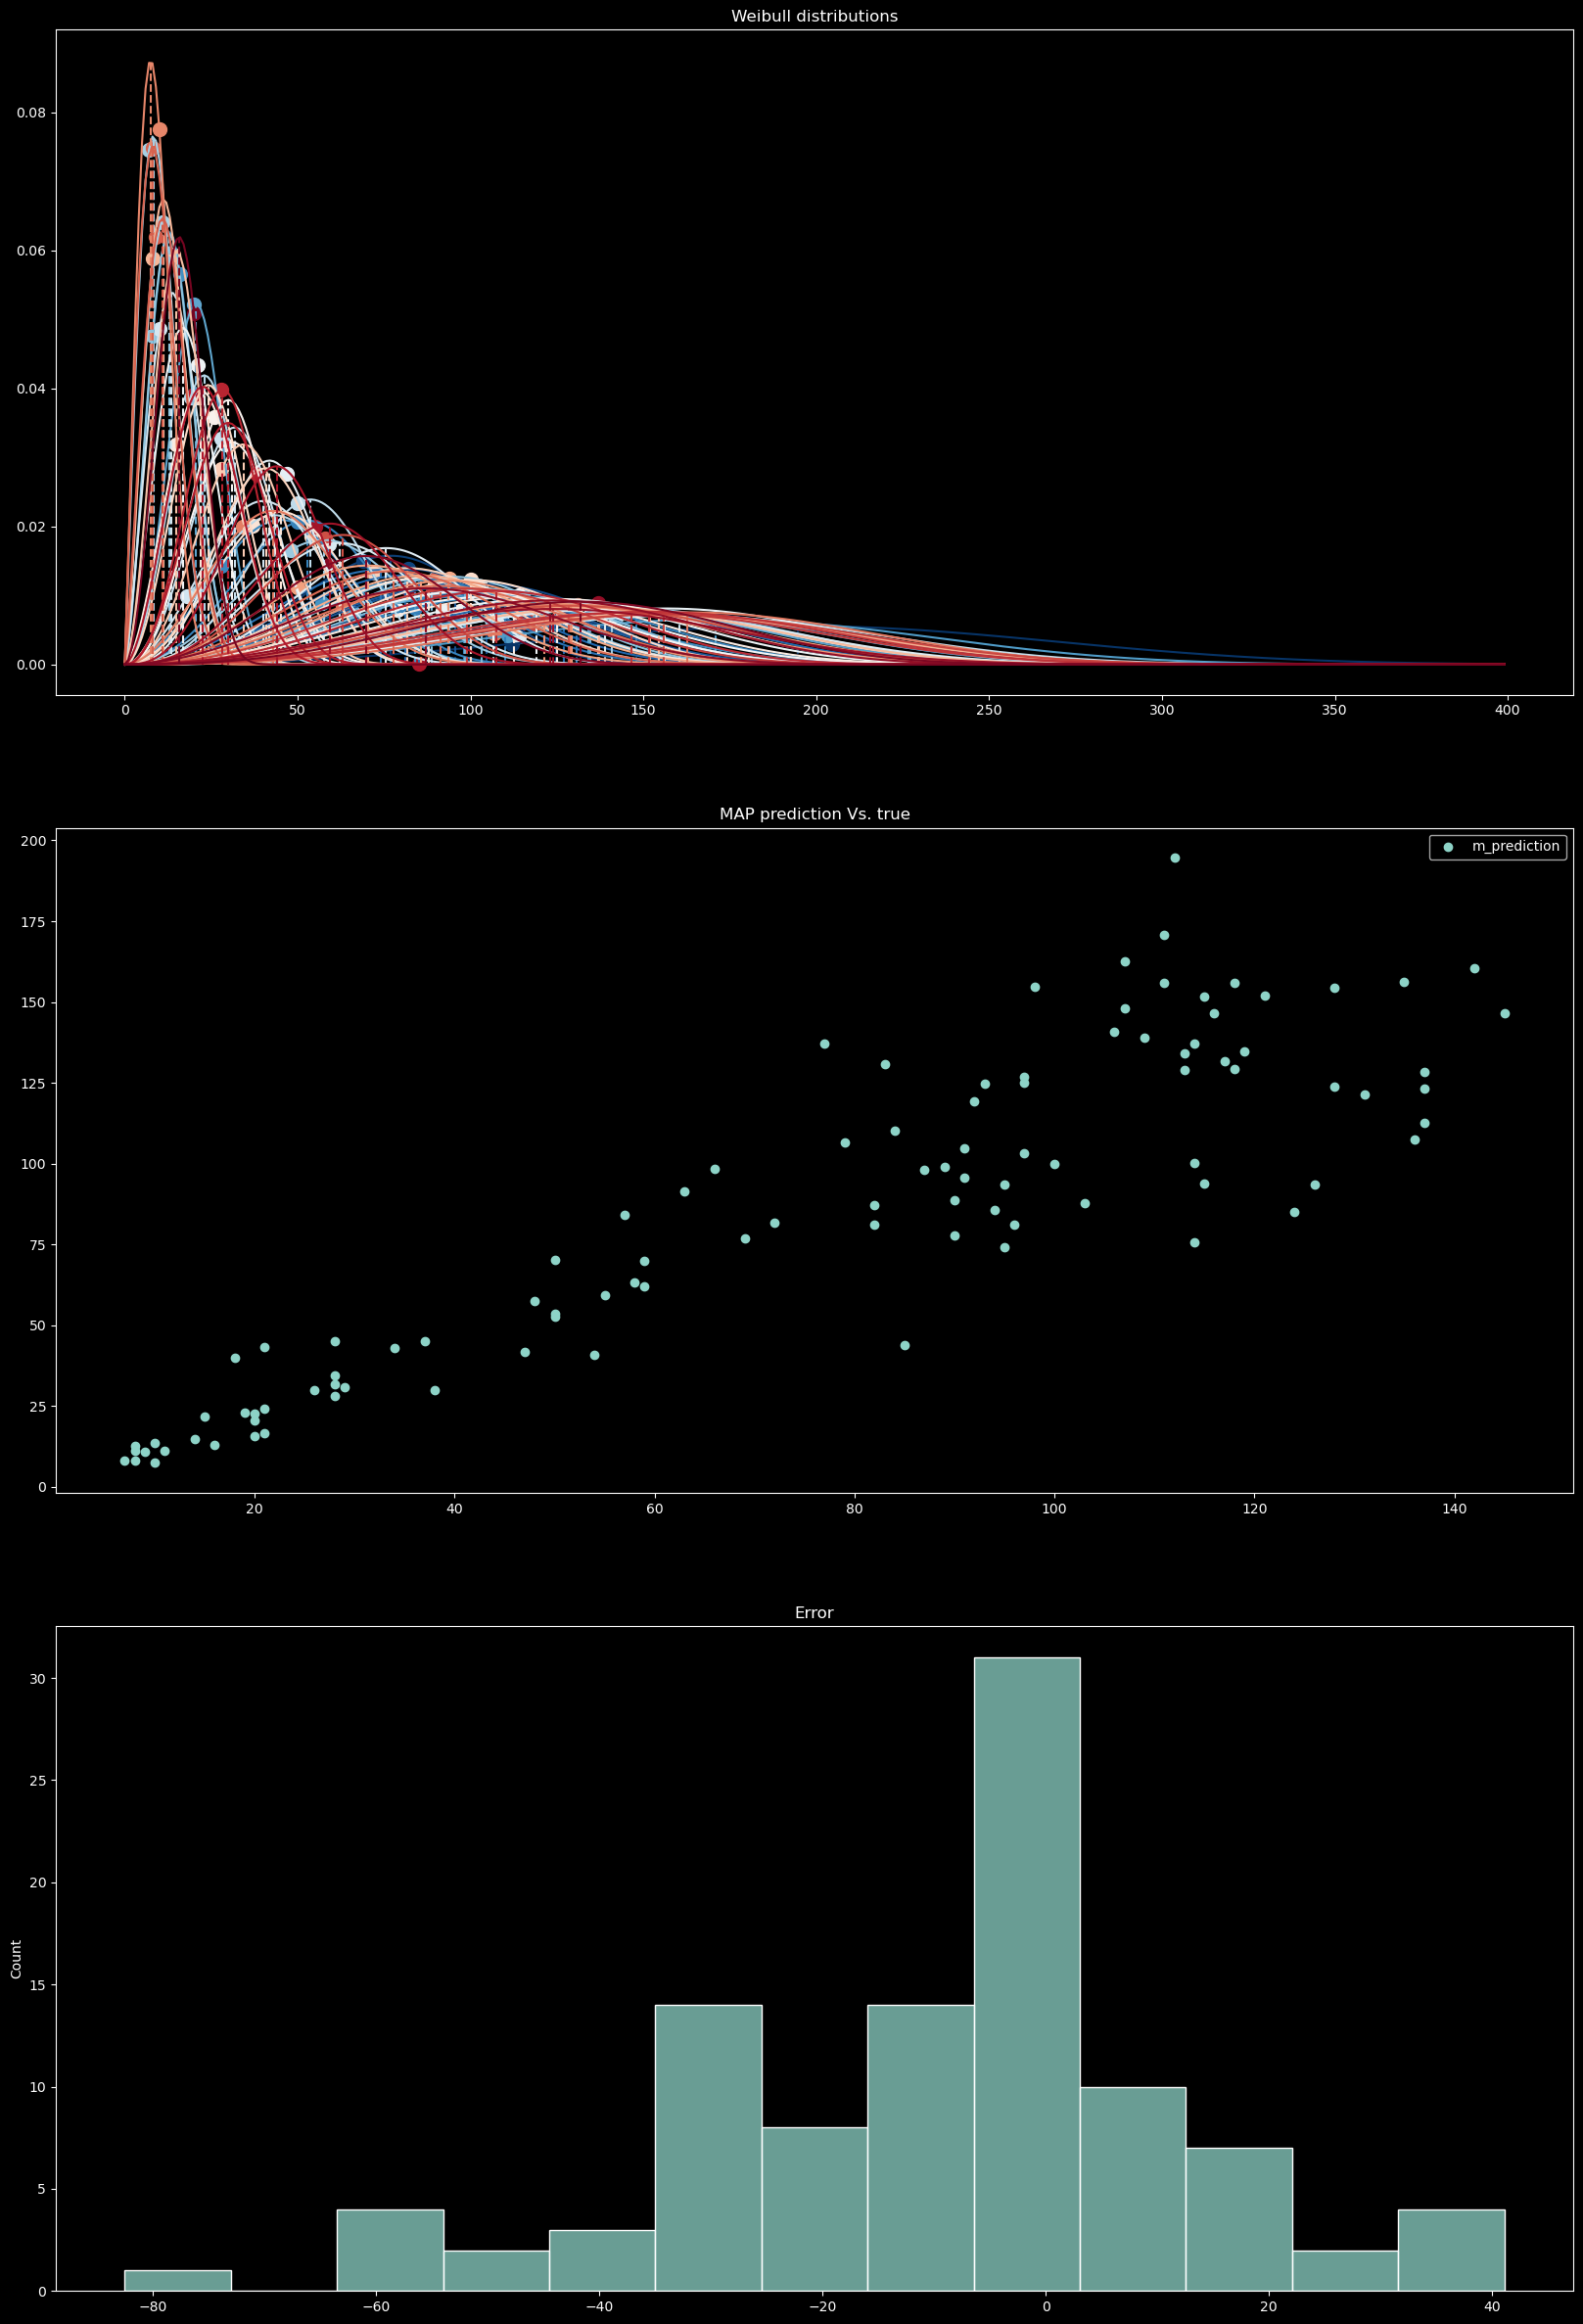

In [32]:
plot_weibull_predictions(results_df=test_results_df)

In [34]:
test_results_df['predicted_mu'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull.mean(row[0], row[1]), axis=1)
test_results_df['predicted_median'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull.quantiles(row[0], row[1], 0.5), axis=1)
test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull.mode(row[0], row[1]), axis=1)

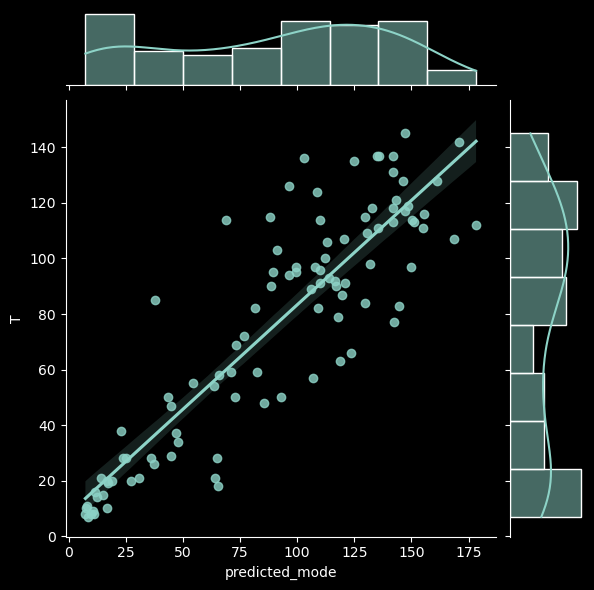

In [41]:
sns.jointplot(data=test_results_df, y='T', x='predicted_mode', kind="reg")

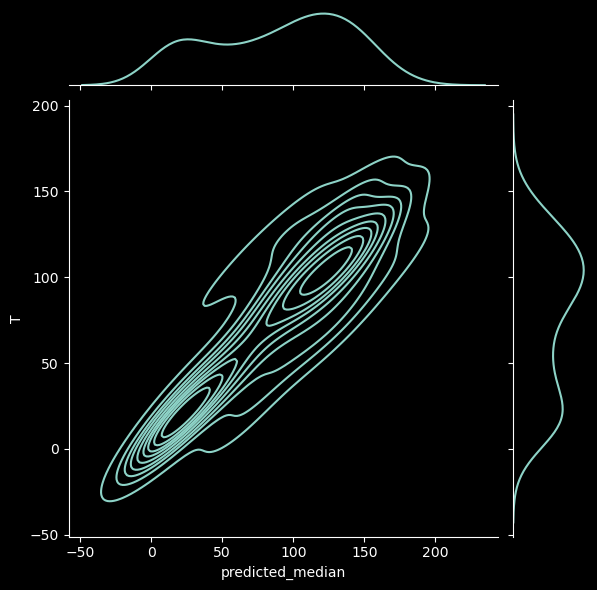

In [42]:
sns.jointplot(data=test_results_df, y='T', x='predicted_median', kind="kde" )

In [35]:
test_results_df['error'] = test_results_df['T']-test_results_df['predicted_median']

In [36]:
test_results_df['error'].describe()

count    100.000000
mean      -9.739594
std       21.839926
min      -83.491169
25%      -23.212663
50%       -5.414276
75%        0.964359
max       41.566020
Name: error, dtype: float64

<AxesSubplot: xlabel='error', ylabel='Count'>

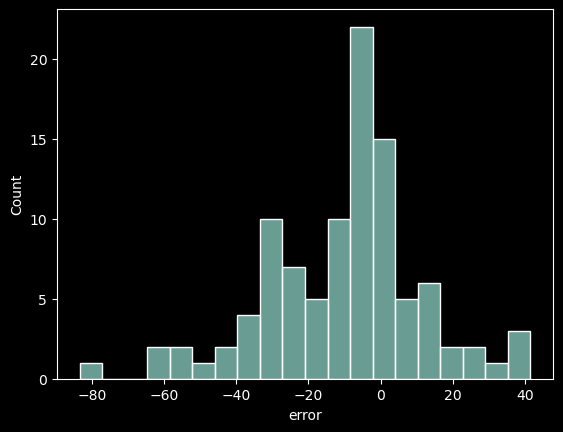

In [37]:
sns.histplot(test_results_df['error'], bins=20)

# Training evaluation

In [38]:
test_y.shape

TensorShape([100, 2])

In [39]:
train_y.shape

TensorShape([20631, 2])

In [40]:
train_predict=model.predict(train_x)
# train_predict = np.resize(train_predict, (20631, 2))

645/645 [==============================] - 546s 846ms/step


In [41]:
train_predict.shape

(20631, 2)

In [42]:
train_result = np.concatenate((train_y, train_predict), axis=1)
train_result.shape

(20631, 4)

In [43]:
train_results_df = pd.DataFrame(train_result, columns=['T', 'E', 'alpha', 'beta'])

In [44]:
train_results_df[['unit_number', 'time']] = train_orig[['unit_number', 'time']]

In [45]:
train_results_df['unit_number'].nunique()

100

In [46]:
train_results_df.shape

(20631, 6)

In [47]:
train_results_df.groupby('unit_number')['beta'].describe()

,count,mean,std,min,25%,50%,75%,max
unit_number,,,,,,,,
1,192.0,3.022217,0.308525,1.731228,2.920880,3.088053,3.226606,3.422041
2,287.0,3.149060,0.362386,1.685927,3.013686,3.220654,3.388951,3.609246
3,179.0,3.099899,0.333108,1.572032,3.048969,3.190719,3.295084,3.478612
4,189.0,3.043949,0.337884,1.568996,3.040668,3.133176,3.196254,3.508958
5,269.0,3.205402,0.379308,1.664318,3.144502,3.317170,3.430222,3.614871
6,188.0,3.124127,0.442363,1.516439,3.021010,3.238734,3.413397,3.758817
7,259.0,3.174686,0.327098,1.797558,3.132866,3.261785,3.354141,3.566843
8,150.0,3.113832,0.408319,1.649066,3.007343,3.235870,3.345151,3.733661
9,201.0,3.178787,0.359083,1.325504,3.106481,3.235767,3.414112,3.591930


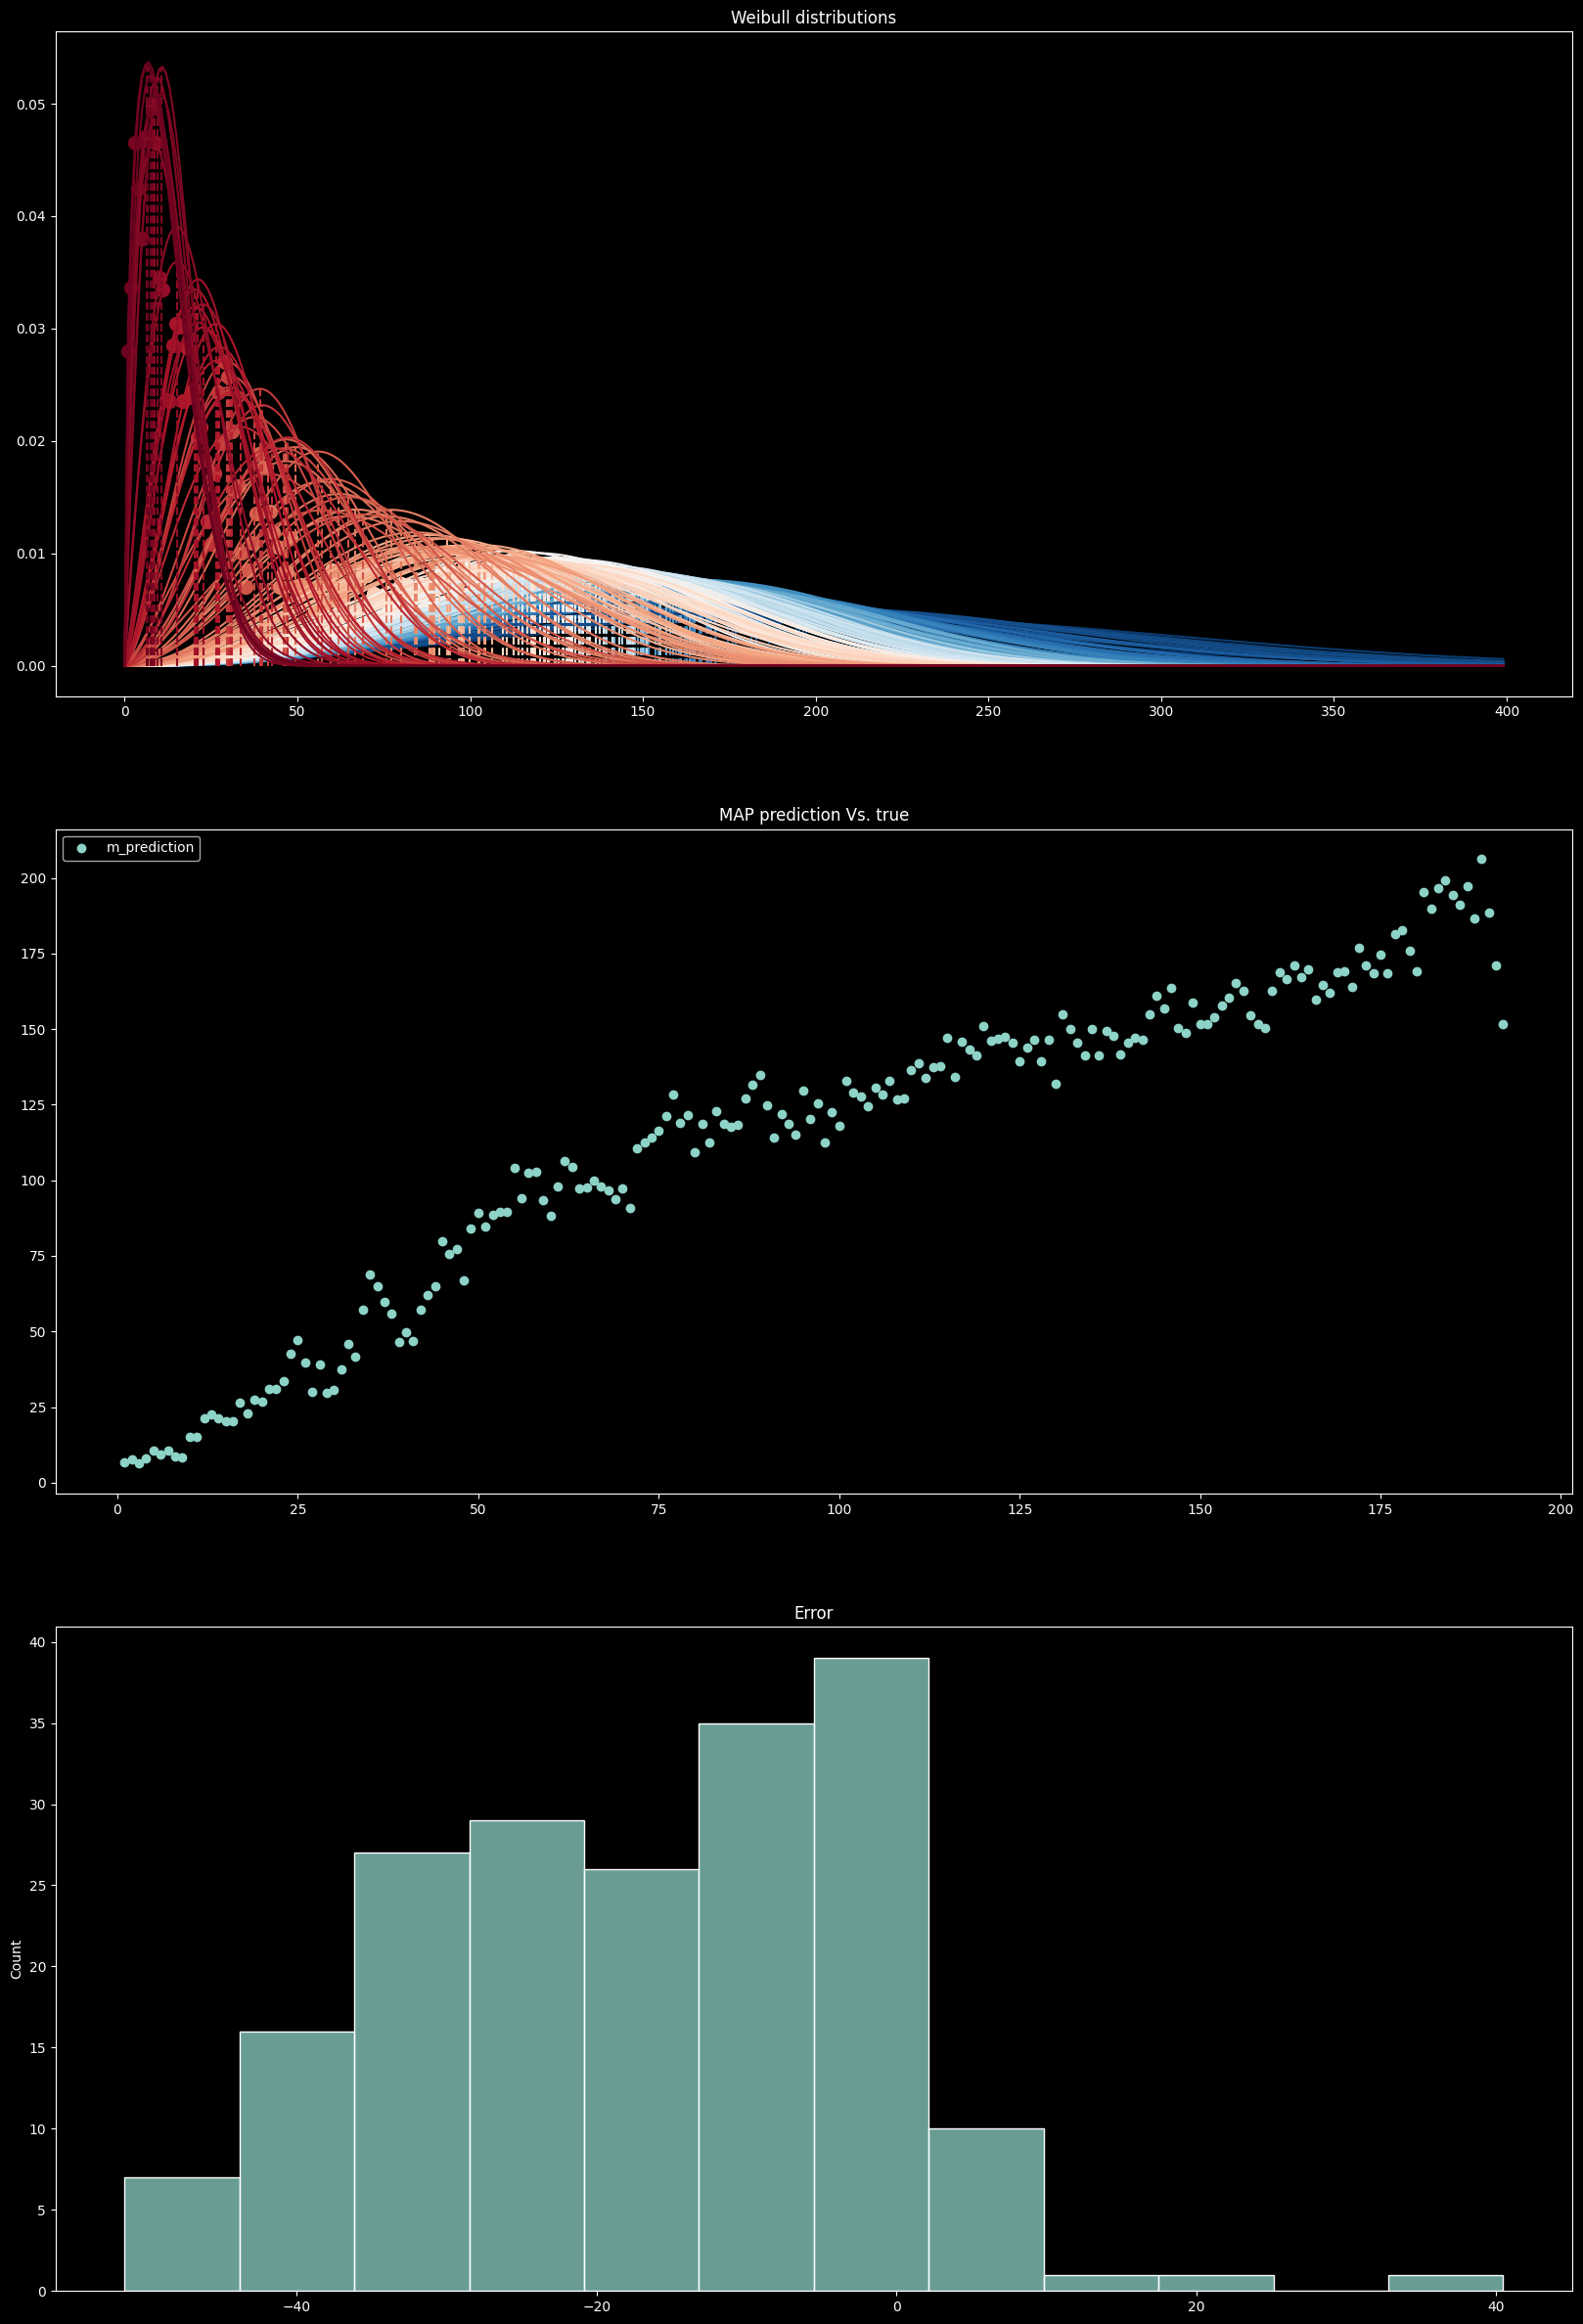

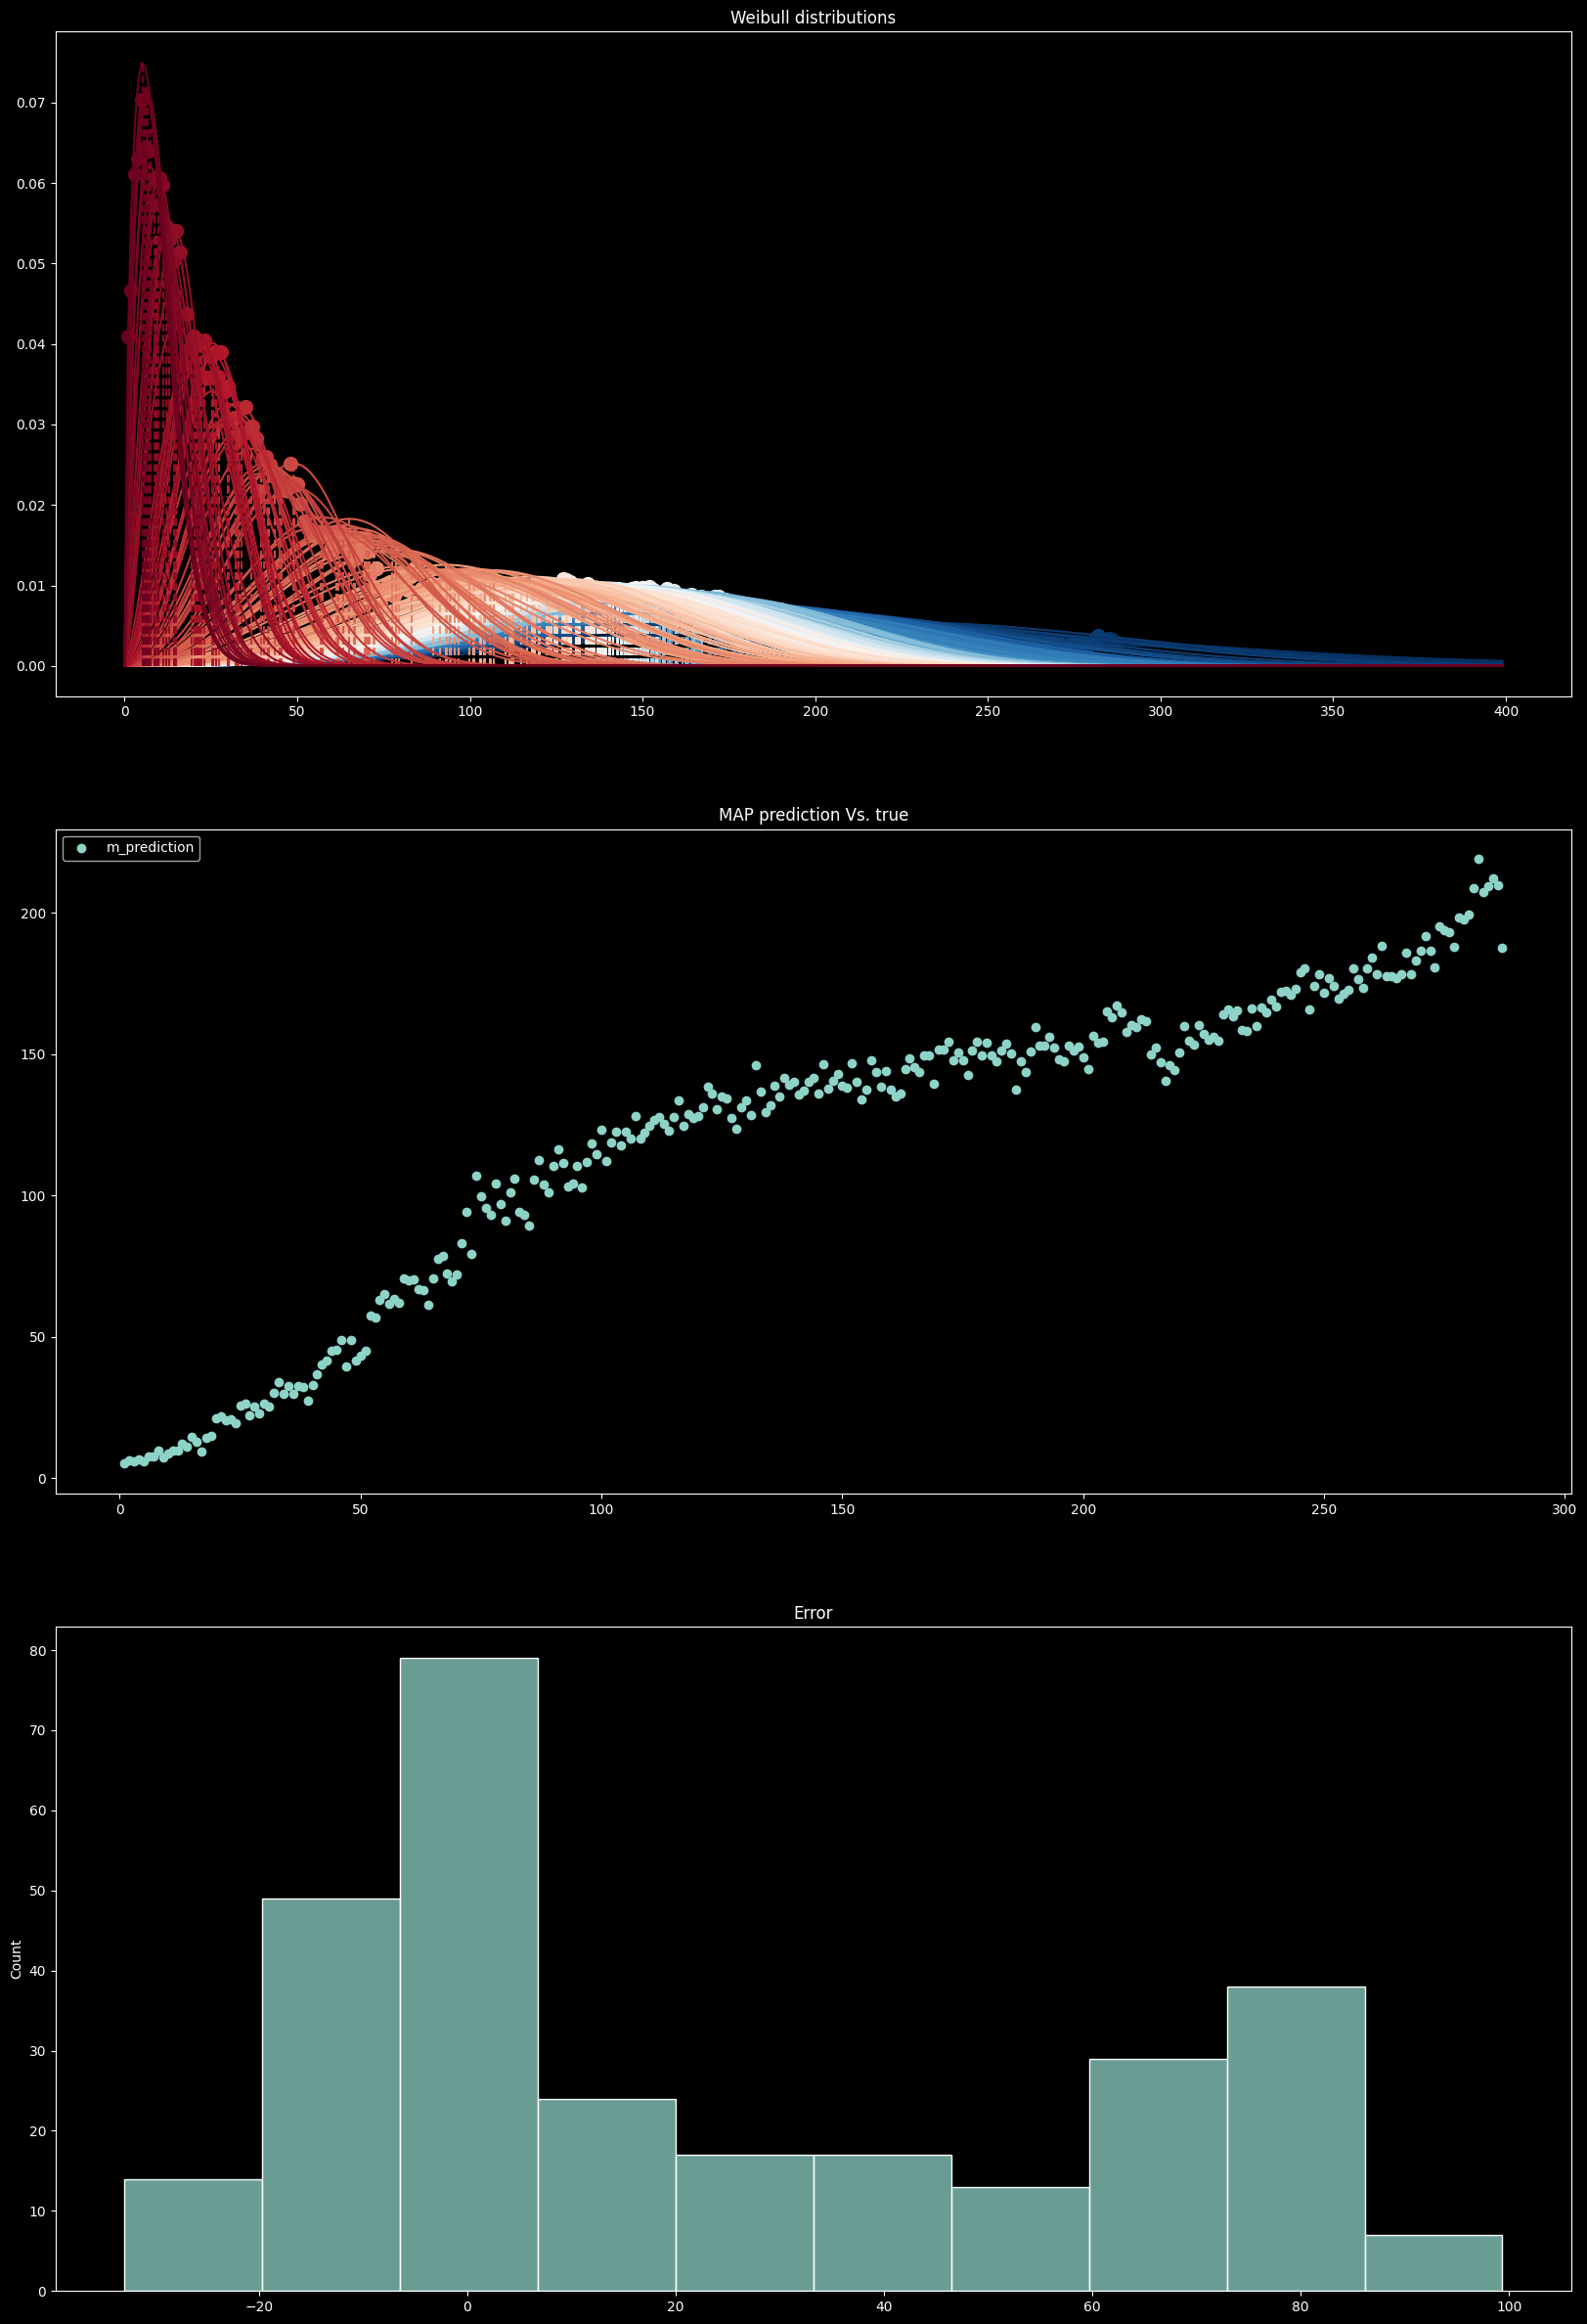

In [74]:
for unit_number, grp in train_results_df.groupby('unit_number'):
    if unit_number < 3:
        plot_weibull_predictions(grp)

In [48]:
train_results_df['predicted_mu'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull.mean(row[0], row[1]), axis=1)
train_results_df['predicted_median'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull.quantiles(row[0], row[1], 0.5), axis=1)

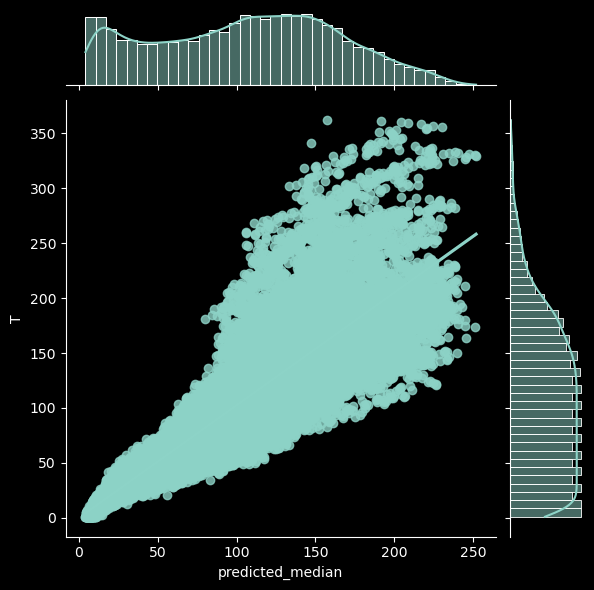

In [49]:
sns.jointplot(data=train_results_df, y='T', x='predicted_median', kind="reg")

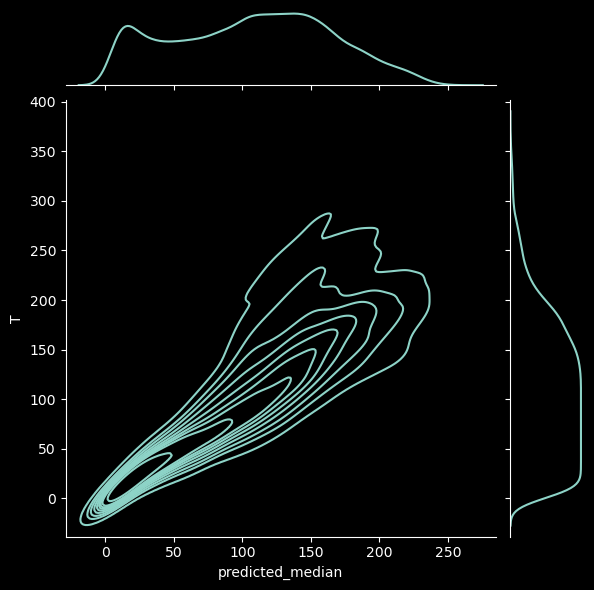

In [50]:
sns.jointplot(data=train_results_df, y='T', x='predicted_median', kind="kde" )

In [51]:
train_results_df['error'] = train_results_df['T']-train_results_df['predicted_median']

In [52]:
train_results_df['error'].describe()

count    20631.000000
mean         2.608611
std         34.845370
min       -105.528821
25%        -16.725420
50%         -2.538987
75%         12.654887
max        204.473120
Name: error, dtype: float64

<AxesSubplot: xlabel='error', ylabel='Count'>

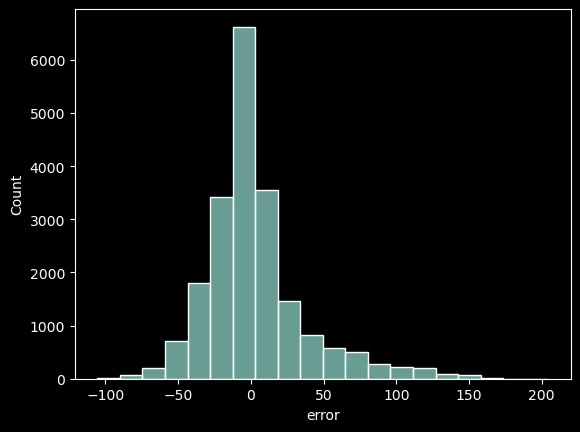

In [53]:
sns.histplot(train_results_df['error'], bins=20)